In [ ]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/MSc_Thesis/'

import os
os.chdir(project_path)

Mounted at /content/drive


In [ ]:
import numpy as np
from utils.helpers_functions import denormalize_mae, read_dataset,mean_with_land_mask, mean_with_coastline_mask
from utils.display_functions import plot_to_compare, plot_history, plot_per_pixel_metrics, plot_degrees_mae, plot_mask_grid
from utils.models_functions import psnr, ssim, load_model, save_model, train_model
from utils.evaluation_functions import evaluate_per_pixel

dates_path='input_data/index/'
lr_data_path='input_data/deg/1x1/'
hr_data_path='input_data/deg/0_5x0_5/'
global_mean = 286.307980744908
global_Std = 64.2568020375484
target_size = (160, 290)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, Dense, Flatten,
                                     Reshape, LeakyReLU, BatchNormalization, Add)
from tensorflow.keras.models import Model

# **Create CAE**
def create_cae():
    input_img = Input(shape=(80, 145, 1))

    # **Encoder** (Feature Extraction)
    x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(input_img)  # (40, 73)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(x)  # (20, 37)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(x)  # (10, 19)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # **Flatten & Dense Bottleneck**
    x_shape = tf.keras.backend.int_shape(x)
    flattened_dim = x_shape[1] * x_shape[2] * x_shape[3]
    x = Flatten()(x)
    bottleneck = Dense(1024, activation='relu')(x)
    x = Dense(flattened_dim, activation='relu')(bottleneck)

    # **Reshape back to feature map**
    x = Reshape((x_shape[1], x_shape[2], x_shape[3]))(x)

    # **Decoder (Upsampling)**
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same')(x)  # (20, 38)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)  # (40, 76)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x)  # (80, 152)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same')(x)  # (160, 304)

    # **Final Cropping to (160, 290)**
    x = x[:, :, :290, :]  # Remove extra width

    # **Compile Model**
    model = Model(inputs=input_img, outputs=x)
    model.compile(optimizer='adam',
                  loss='mae',
                  metrics=[psnr, ssim, 'mse', 'mae'])

    return model

In [ ]:
trainX, valX, testX, trainY, valY, testY, trainDates, valDates, testDates = read_dataset(project_path, dates_path, lr_data_path, hr_data_path, \
                                                                                         'all', 2000, 2020, global_mean, global_Std)

print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)

(21478, 80, 145, 1)
(21478, 160, 290, 1)
(4602, 80, 145, 1)
(4602, 160, 290, 1)


In [ ]:
# Initialize the model
autoencoder_model = create_cae()
autoencoder_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 80, 145, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 40, 73, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 73, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 40, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 20, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 19, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 19, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 10, 19, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 48640)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      49,808,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 48640)               │      49,856,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 10, 19, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 20, 38, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 20, 38, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 20, 38, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 40, 76, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 40, 76, 64)          │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 100,424,321 (383.09 MB)

 Trainable params: 100,422,977 (383.08 MB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 48s 166ms/step - loss: 0.0927 - mae: 0.0927 - mse: 0.0303 - psnr: 20.0795 - ssim: 0.4263 - val_loss: 0.1344 - val_mae: 0.1344 - val_mse: 0.0329 - val_psnr: 14.8256 - val_ssim: 0.3138 - learning_rate: 0.0010
Epoch 2/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0326 - mae: 0.0326 - mse: 0.0021 - psnr: 26.7100 - ssim: 0.7388 - val_loss: 0.1019 - val_mae: 0.1019 - val_mse: 0.0211 - val_psnr: 16.7654 - val_ssim: 0.4936 - learning_rate: 0.0010
Epoch 3/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0282 - mae: 0.0282 - mse: 0.0016 - psnr: 28.0534 - ssim: 0.7746 - val_loss: 0.0614 - val_mae: 0.0614 - val_mse: 0.0075 - val_psnr: 21.2521 - val_ssim: 0.6972 - learning_rate: 0.0010
Epoch 4/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0249 - mae: 0.0249 - mse: 0.0012 - psnr: 29.1879 - ssim: 0.8105 - val_loss: 0.0291 - val_mae: 0.0291 - val_mse: 0.0017 - val_psnr: 27.6824 - val_ssim: 0.8163 - learning_rate: 0.0010
Epoch 5/200
16

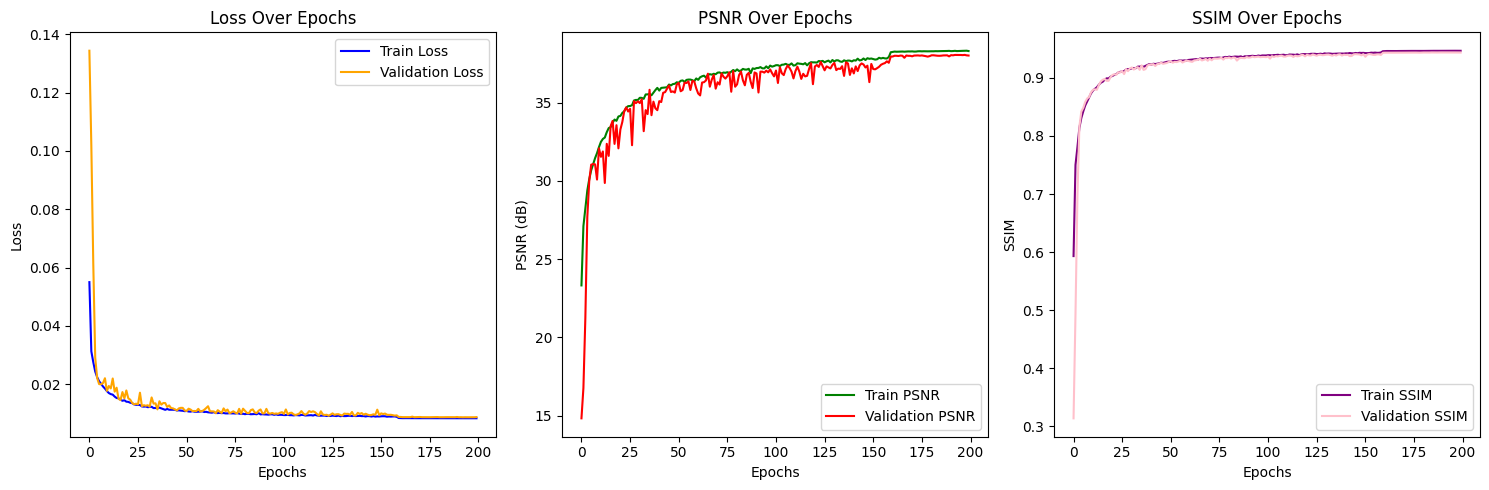

In [ ]:
history = train_model(autoencoder_model, trainX, trainY, valX, valY, 200, 128, True, True, 50, 40)

plot_history(history)
save_model(autoencoder_model, 'models/cae_model_1to0_5_deg_200epochs.keras')

In [ ]:
# autoencoder_model = tf.keras.models.load_model('models/cae_model_1to0_5_deg_200epochs.keras', custom_objects={'psnr': psnr, 'ssim': ssim})

In [ ]:
test_loss, test_psnr, test_ssim, test_mse, test_mae = autoencoder_model.evaluate(testX, testY)

print(f"Test Loss: {test_loss}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0086 - mae: 0.0086 - mse: 1.5786e-04 - psnr: 38.0207 - ssim: 0.9435
Test Loss: 0.008653356693685055
Test PSNR: 38.01516342163086
Test SSIM: 0.9435330033302307
Test MSE: 0.0001580567768542096
Test MAE: 0.008653356693685055


In [ ]:
low_res_input = testX[1]
high_res_data = testY[1]
high_res_output = autoencoder_model.predict(np.expand_dims(low_res_input, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


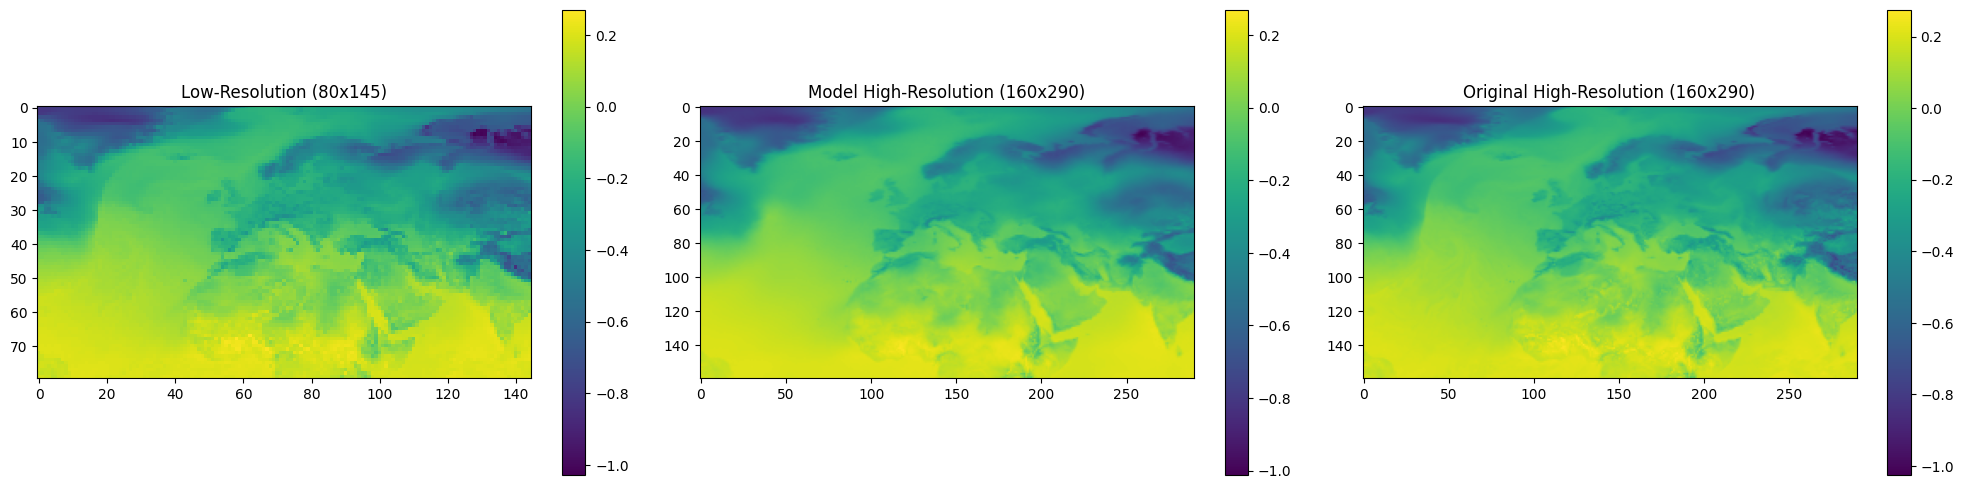

In [ ]:
plot_to_compare(low_res_input, np.squeeze(high_res_data),  np.squeeze(high_res_output), 'viridis')

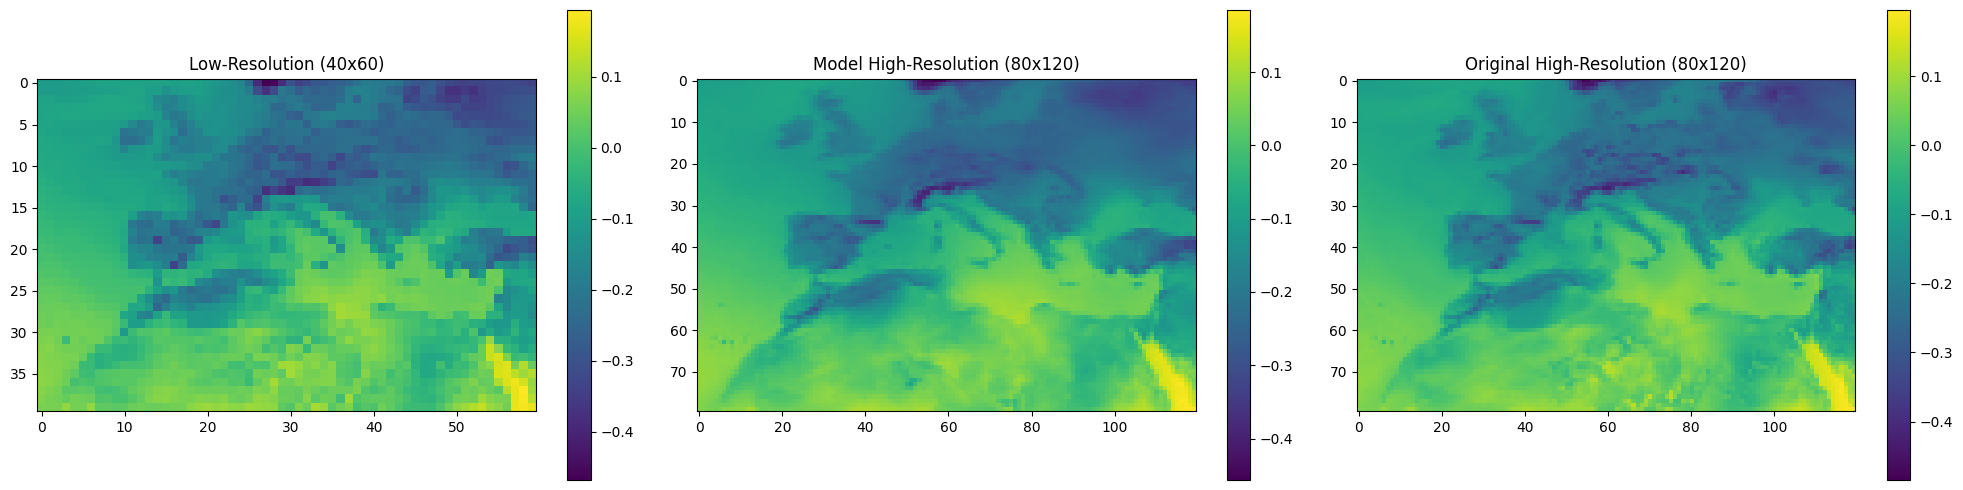

In [ ]:
plot_to_compare(low_res_input[20:60, 40:100], np.squeeze(high_res_data)[40:120, 80:200],  np.squeeze(high_res_output)[40:120, 80:200], 'viridis')

In [ ]:
# Compute per-pixel metrics
test_mse, test_mae, test_psnr, test_ssim = evaluate_per_pixel(autoencoder_model, testX, testY)

print("Per-pixel MSE shape:", test_mse.shape)
print("Per-pixel MAE shape:", test_mae.shape)
print("Per-pixel PSNR shape:", test_psnr.shape)
print("Per-pixel SSIM shape:", test_ssim.shape)

mean_mse = np.mean(test_mse)
mean_mae = np.mean(test_mae)
mean_psnr = np.mean(test_psnr)
mean_ssim = np.mean(test_ssim)

print("Mean Per-Pixel MSE:", mean_mse)
print("Mean Per-Pixel MAE:", mean_mae)
print("Mean Per-Pixel PSNR:", mean_psnr)
print("Mean Per-Pixel SSIM:", mean_ssim)

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Per-pixel MSE shape: (160, 290, 1)
Per-pixel MAE shape: (160, 290, 1)
Per-pixel PSNR shape: (160, 290, 1)
Per-pixel SSIM shape: (160, 290, 1)
Mean Per-Pixel MSE: 0.0001580567
Mean Per-Pixel MAE: 0.008653355
Mean Per-Pixel PSNR: 39.502945
Mean Per-Pixel SSIM: 0.98134595


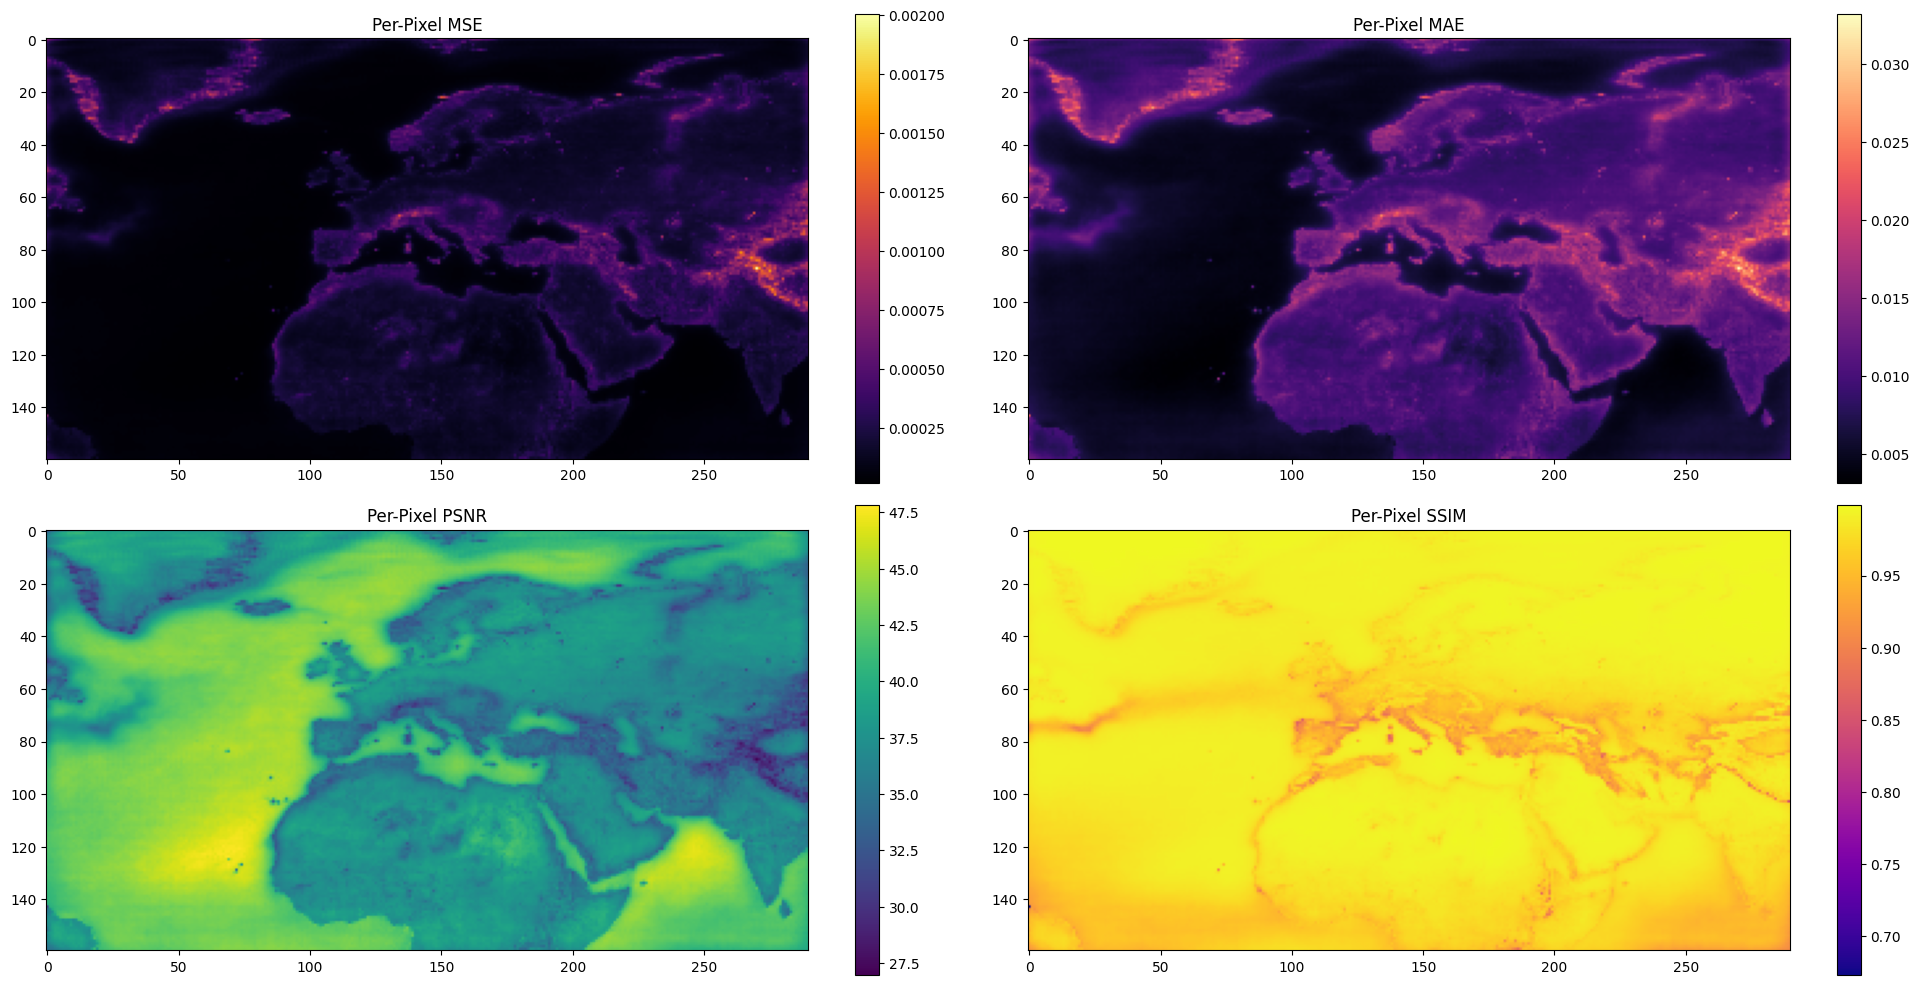

In [ ]:
# Plot results
plot_per_pixel_metrics(test_mse, test_mae, test_psnr, test_ssim)

Mean Per-Pixel Degrees MAE: 0.55603695
Max Degrees MAE: 2.1364248
Min Degrees MAE: 0.20235898


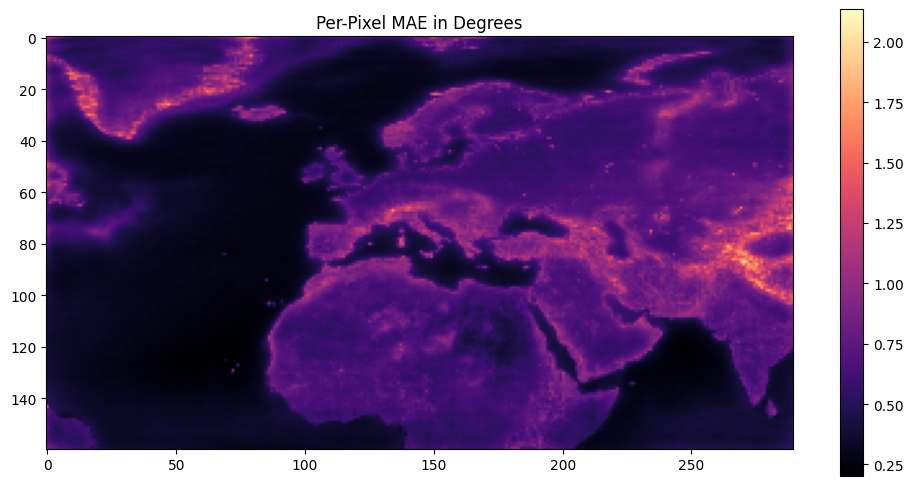

In [ ]:
degrees_mae = denormalize_mae(test_mae, global_Std)
print("Mean Per-Pixel Degrees MAE:", np.mean(degrees_mae))
print("Max Degrees MAE:", degrees_mae.max())
print("Min Degrees MAE:", degrees_mae.min())
plot_degrees_mae(degrees_mae)

In [ ]:
print("Mean Land-Pixels Degrees MAE:", mean_with_land_mask(degrees_mae, '0_5'))
print("Mean Land-Pixels MAE:", mean_with_land_mask(test_mae, '0_5'))

Mean Land-Pixels Degrees MAE: 0.7287397
Mean Land-Pixels MAE: 0.011341051


In [ ]:
print("Mean Coastline-Pixels Degrees MAE:", mean_with_coastline_mask(degrees_mae, '0_5'))
print("Mean Costline-Pixels MAE:", mean_with_coastline_mask(test_mae, '0_5'))

Mean Coastline-Pixels Degrees MAE: 0.7558772
Mean Costline-Pixels MAE: 0.01176338
